In [1]:
import os
import time
import numpy as np

from simtk import unit
from simtk.openmm import app, LangevinIntegrator
from simtk.openmm.app import PDBFile

import parmed as pmd

from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField

import matplotlib.pyplot as plt
import mpld3

Unable to load toolkit <openforcefield.utils.toolkits.OpenEyeToolkitWrapper object at 0x7f1c76eab7f0>.


In [2]:
# choose the force field:
# not yet the release version!
openff_forcefield = ForceField('smirnoff99Frosst-1.1.0.offxml')

In [3]:
# function to convert openFF molecule (ligand) to a parmed structure
def ligandToPMD(ligand):
    ligand_positions = ligand.conformers[0]
    
    # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
    try:
        ligand.compute_partial_charges_am1bcc()
    except Exception as e:
        raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
    # Give all atoms unique names so we can export to GROMACS
    for idx, atom in enumerate(ligand.atoms):
        atom.name = f'{atom.element.symbol}{idx}'
    
    # Do not assign H-bond constraints now, instead have ParmEd add them later
    del openff_forcefield._parameter_handlers['Constraints']

    ligand_topology = ligand.to_topology()
    try:
        ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
    except Exception as e:
        raise Exception('Error in creating openmm system: {}'.format(e))
    # Create OpenMM Topology from OpenFF Topology
    omm_top = ligand_topology.to_openmm()


    # Convert OpenMM System to a ParmEd structure.
    pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)

    return pmd_structure, ligand_topology, ligand_system, ligand_positions

In [4]:
# function for analyzing energy contributions of openMM energies
def forcegroupify(system):
    forcegroups = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        force.setForceGroup(i)
        forcegroups[(type(force)).__name__] = i
    return forcegroups

def getEnergyDecomposition(context, forcegroups):
    energies = {}
    for f, i in forcegroups.items():
        energies[f] = context.getState(getEnergy=True, groups=2**i).getPotentialEnergy()
    energies['TotalPotential'] = context.getState(getEnergy=True).getPotentialEnergy()
    return energies

# Create gromacs topologies and coordinates of simple test molecules

In [5]:
# create simple test molecules
target = 'testmols'
print('=== ' + target + ' ===')
names = ['methane', 'ethane', 'ethanol', 'acetone', 'benzene', 'phenol', 'benzaldehyde']
smiles = ['C', 'CC', 'CCO', 'CC(=O)C', 'c1ccccc1', 'c1ccccc1O', 'c1ccccc1C=O']
for lig, smi in zip(names, smiles):
    print('    ', lig)
    ligand = Molecule.from_smiles(smi)
    ligand.name = lig
    ligand.generate_conformers()
    
    ligPath = 'systems/' + target + '/' + lig 
    ! mkdir -p $ligPath
    ligPath += '/' + lig
    
    # Export sdf file
    ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
    try: 
        pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
    except Exception as e:
        print('    ' + str(e))
        continue
       
    # Export GROMACS files.
    pmd_structure.save(ligPath+'.top', overwrite=True)
    pmd_structure.save(ligPath+'.gro', overwrite=True)

=== testmols ===
     methane


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'methane' has more than one conformer, but this function will only generate charges for the first one.


     ethane


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'ethane' has more than one conformer, but this function will only generate charges for the first one.


     ethanol


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'ethanol' has more than one conformer, but this function will only generate charges for the first one.


     acetone


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'acetone' has more than one conformer, but this function will only generate charges for the first one.


     benzene
     phenol
     benzaldehyde


# Convert pdb files to gromacs topologies

In the last version I first converted the pdb files first to sdf with openbabel - let the openFF toolkit (only works with OpenEye) do it on itself.

ATTENTION: this might prone to errors because the pdb files do not have bond information

In [6]:
for target in ['jnk1', 'pde2', 'thrombin']:
    print('=== ' + target + ' ===')
    ligands = ! ls -d "systems/"$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath= 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath + '.pdb'):
            print('   ', lig[-2])
            
            # Try to read in PDB file (original), only works with OpenEye
            # Otherwise the SDF file (not original, converted from PDB) is used
            try:
                ligand = Molecule.from_file(ligPath + '.pdb')
                # save as sdf file
                ligand.to_file(ligPath+'.sdf', 'sdf')
            except Exception as e:
                print('    ' + str(e))
                if os.path.isfile(ligPath + '.sdf'):
                    print('    Using the SDF file')
                    ligand = Molecule.from_file(ligPath + '.sdf')
                else:
                    print('    Molecules {} cannot be read in'.format(lig[-2]))
            
            try: 
                pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
            except Exception as e:
                print('    ' + str(e))
                continue

            # Export GROMACS files.
            pmd_structure.save(ligPath+'.top', overwrite=True)
            pmd_structure.save(ligPath+'.gro', overwrite=True)

=== jnk1 ===
    lig_17124-1
    No toolkits in registry can read file systems/jnk1/lig_17124-1/lig_17124-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18624-1
    No toolkits in registry can read file systems/jnk1/lig_18624-1/lig_18624-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18625-1
    No toolkits in registry can read file systems/jnk1/lig_18625-1/lig_18625-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18626-1
    No toolkits in registry can read file systems/jnk1/lig_18626-1/lig_18626-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig

    lig_49580115
    No toolkits in registry can read file systems/pde2/lig_49580115/lig_49580115.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_49582390
    No toolkits in registry can read file systems/pde2/lig_49582390/lig_49582390.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_49582468
    No toolkits in registry can read file systems/pde2/lig_49582468/lig_49582468.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_49585367
    No toolkits in registry can read file systems/pde2/lig_49585367/lig_49585367.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_

# Use SDF files with coordinates of PDB files

This only works for the PDE2 ligands. SDF file of supporting information of https://www.nature.com/articles/s41598-018-23039-5

In [12]:
print('=== pde2_sdf ===')
target = 'pde2_sdf'
ligands = Molecule.from_file('systems/pde2_sdf/4D08_ligands_input.sdf', 'sdf')
for ligand in ligands:
    
    # try to find a pdb matching the ligand from the SDF file
    pdbtarget = 'pde2'
    pdbligands = ! ls -d 'systems/'$pdbtarget/*/
    for pdblig in pdbligands:
        pdblig = pdblig.split('/')
        pdbligPath = 'systems/' + pdbtarget + '/' + pdblig[-2] + '/' + pdblig[-2]
        
        if os.path.isfile(pdbligPath+'.pdb'):
            pdb = app.PDBFile(pdbligPath + ".pdb")
            openmm_topology = pdb.topology
            try:
                ligand_topology = Topology.from_openmm(openmm_topology, unique_molecules=[ligand])
                print('    {}    {}'.format(ligand.name, pdblig[-2]))
                break
            except:
                continue
    else:
        print('PDB coordinates not found')
    
    
    # the following try statement is a custom version of the function ligandToPMD above
    try:
        # get pdb positions
        ligand_positions = pdb.getPositions()
            
        # set ligand conformer to pdb positions, Attention: This only works if the order of atoms is the same in the pdb file and the ligand class
        ligand.conformers[0] = unit.Quantity(np.array(ligand_positions.value_in_unit(unit.angstrom)), unit.angstrom)
            
        # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
        try:
            ligand.compute_partial_charges_am1bcc()
        except Exception as e:
            raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
        # Give all atoms unique names so we can export to GROMACS
        for idx, atom in enumerate(ligand.atoms):
            atom.name = f'{atom.element.symbol}{idx}'
            ligand_topology.atom(idx).atom.name = atom.name

        # Do not assign H-bond constraints now, instead have ParmEd add them later
        del openff_forcefield._parameter_handlers['Constraints']

        try:
            ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
        except Exception as e:
            raise Exception('Error in creating openmm system: {}'.format(e))
        # Create OpenMM Topology from OpenFF Topology
        omm_top = ligand_topology.to_openmm()


        # Convert OpenMM System to a ParmEd structure.
        pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)
    except Exception as e:
        print('    ' + str(e))
        continue

    # Output path.
    ligPath = 'systems/' + target + '/' + lig[-2] 
    ! mkdir -p $ligPath
    ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
    # Export single SDF file
    ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
    # Export GROMACS files.        
    pmd_structure.save(ligPath+'.top', overwrite=True)
    pmd_structure.save(ligPath+'.gro', overwrite=True)

=== pde2_sdf ===
    2    lig_43249674


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   48  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  , HETATM   30  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   31  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  , HETATM    1  H   Q2T A1918      -3.091  22.411  18.274  0.00 18.25           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstruct

    4    lig_49137530
    6    lig_48009208
    7    lig_48022468
    8    lig_48168913
    9    lig_49137374
    10    lig_48271249


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   33  C   Q2T A1918      -5.453  22.635  17.072  0.00  0.00           C  , HETATM    6  C   Q2T A1918      -0.096  21.639  19.622  0.00 18.14           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   56  H   Q2T A1918      -5.421  21.581  16.797  0.00  0.00           H  , HETATM   54  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstruct

    11    lig_49220392
    12    lig_49580115
    13    lig_49220548
    14    lig_49396360
    15    lig_49175828
    16    lig_49072088


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   52  C   Q2T A1918      -4.328  24.628  18.529  0.00  0.00           C  , HETATM   51  C   Q2T A1918      -5.107  25.522  17.600  0.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   53  C   Q2T A1918      -5.531  25.378  19.038  0.00  0.00           C  , HETATM   52  C   Q2T A1918      -4.328  24.628  18.529  0.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstruct

    17    lig_49582468


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   56  H   Q2T A1918      -3.585  21.519  17.446  0.00  0.00           H  , HETATM   55  H   Q2T A1918      -2.900  22.990  17.111  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    18    lig_49932129
    19    lig_49932714
    20    lig_49585367
    21    lig_49175789


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   60  H   Q2T A1918      -3.584  21.515  17.446  0.00  0.00           H  , HETATM   59  H   Q2T A1918      -2.901  22.988  17.111  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    22    lig_50181001
    23    lig_50107616
    24    lig_49582390


# Run single point energies and minimizations in openMM and Gromacs

In [13]:
# initialize dicts to store gromacs and openMM energies
gromacsEnergies = {}
openmmEnergies = {}
gromacsMinimizedEnergies = {}
openmmMinimizedEnergies = {}

#### openMM

In [14]:
 # run it in openMM
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    openmmEnergies[target] = {}
    openmmMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            gro_positions = pmd.load_file(ligPath + '.gro')
            
            ligand_topology = pmd.load_file(ligPath + '.top', box = gro_positions.box)
            ligand_system = ligand_topology.createSystem(nonbondedMethod = app.NoCutoff, removeCMMotion = False)

            integrator = LangevinIntegrator(300*unit.kelvin, 
                            1/unit.picosecond, 
                            0.002*unit.picoseconds)

             
            simulation = app.Simulation(ligand_topology, ligand_system, integrator)
        
            simulation.context.setPositions(gro_positions.positions)
        
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            openmmEnergies[target][lig[-2]] = energies
            print('     Estart : {}'.format(energies['TotalPotential']))
    
            simulation.minimizeEnergy()
            minimized_coords = simulation.context.getState(getPositions=True).getPositions()
            
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            openmmMinimizedEnergies[target][lig[-2]] = energies
            print('     Emin   : {}'.format(energies['TotalPotential']))

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
     Emin  : -56.58202362060547 kJ/mol
     Estart: -73.88175964355469 kJ/mol
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
     Emin  : 71.5277099609375 kJ/mol
     Estart: 55.67148971557617 kJ/mol
------------------------------------------------------------
--- benzene ---
------------------------------------------------------------
     Emin  : 41.46055603027344 kJ/mol
     Estart: 23.455997467041016 kJ/mol
------------------------------------------------------------
--- ethane ---
------------------------------------------------------------
     Emin  : 24.27559471130371 kJ/mol
     Estart: 4.434347629547119 kJ/mol
------------------------------------------------------------
--- ethanol ---
--------------------------------------------

     Emin  : 314.3883361816406 kJ/mol
     Estart: 191.76730346679688 kJ/mol
------------------------------------------------------------
--- lig_49175828 ---
------------------------------------------------------------
     Emin  : 283.441162109375 kJ/mol
     Estart: 165.61318969726562 kJ/mol
------------------------------------------------------------
--- lig_49220392 ---
------------------------------------------------------------
     Emin  : 294.0843200683594 kJ/mol
     Estart: 179.13909912109375 kJ/mol
------------------------------------------------------------
--- lig_49220548 ---
------------------------------------------------------------
     Emin  : 305.4751892089844 kJ/mol
     Estart: 190.71438598632812 kJ/mol
------------------------------------------------------------
--- lig_49396360 ---
------------------------------------------------------------
     Emin  : 321.86602783203125 kJ/mol
     Estart: 213.927001953125 kJ/mol
---------------------------------------------

     Estart: 352.2415466308594 kJ/mol
------------------------------------------------------------
--- lig_49580115 ---
------------------------------------------------------------
     Emin  : 453.73822021484375 kJ/mol
     Estart: 344.4913635253906 kJ/mol
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
     Emin  : 634.8155517578125 kJ/mol
     Estart: 503.9355163574219 kJ/mol
------------------------------------------------------------
--- lig_49582468 ---
------------------------------------------------------------
     Emin  : 296.9137878417969 kJ/mol
     Estart: 175.85418701171875 kJ/mol
------------------------------------------------------------
--- lig_49585367 ---
------------------------------------------------------------
     Emin  : 491.44403076171875 kJ/mol
     Estart: 385.51812744140625 kJ/mol
------------------------------------------------------------
--- lig_49932129 ---


#### Gromacs

In [15]:
# needed to have some sleep times between the system calls because writing of files was not yet finished
# run gromacs to get energies
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    gromacsEnergies[target] = {}
    gromacsMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            dir = 'systems/' + target + '/' + lig[-2]
            ! rm -f $dir/\#*
            
            # single point energy of starting structure
            energies = ''
            count = 0
            while not energies and count < 10:
                print('    Calculate single-point energy ...')
                os.system("gmx grompp -f ./input/gromacs/md.mdp -c {}.gro -p {}.top -o {}_md.tpr &> {}_grompp.out".format(ligPath, ligPath, ligPath, ligPath))
                time.sleep(2)
                os.system("gmx mdrun  -s {}_md.tpr -rerun {}.gro -e {}.edr -g {}.log &> {}_mdrun.out".format(ligPath, ligPath, ligPath, ligPath, ligPath))
                time.sleep(2)
                energies = ! cat $ligPath'.log' | grep -A 4 "Energies"
                count += 1
            ene_dict = {'Bond': 0.0, 'Angle': 0.0, 'Proper Dih.': 0.0, 'LJ-14': 0.0, 'Coulomb-14': 0.0, 'LJ (SR)': 0.0, 'Coulomb (SR)': 0.0, 'Potential': 0.0}
            for i in range(int((len(energies)-1)/2)):
                keys = [s.strip() for s in energies[1+i*2].split('  ') if s]
                values = energies[2+i*2].split()
                for key, val in zip(keys, values):
                    ene_dict[key] = float(val)
            print('    ' + str(ene_dict))
            gromacsEnergies[target][lig[-2]] = ene_dict
                        
            # energy minimization
            minEnergies = ''
            count = 0
            while not minEnergies and count < 10:
                print('    Energy minimize ligand ...')
                os.system("gmx grompp -f ./input/gromacs/minim.mdp -c {}.gro -p {}.top -o {}_em.tpr &> {}_grompp_em.out".format(ligPath, ligPath, ligPath, ligPath))
                os.system("gmx mdrun  -deffnm {}_em &> {}_mdrun_em.out".format(ligPath, ligPath))
                time.sleep(2)
                # getting the last energies entry
                minEnergies = ! tac $ligPath'_em.log' | grep -m 1 -B 4 "Energies" | tac 
                count += 1
            
            minEne_dict = {'Bond': 0.0, 'Angle': 0.0, 'Proper Dih.': 0.0, 'LJ-14': 0.0, 'Coulomb-14': 0.0, 'LJ (SR)': 0.0, 'Coulomb (SR)': 0.0, 'Potential': 0.0}
            for i in range(int((len(minEnergies)-1)/2)):
                keys = [s.strip() for s in minEnergies[1+i*2].split('  ') if s]
                values = minEnergies[2+i*2].split()
                for key, val in zip(keys, values):
                    minEne_dict[key] = float(val)
            print('    ' + str(minEne_dict))
            gromacsMinimizedEnergies[target][lig[-2]] = minEne_dict

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 10.3407, 'Angle': 6.06319, 'Proper Dih.': 22.0362, 'LJ-14': 1.99935, 'Coulomb-14': -110.627, 'LJ (SR)': -0.327426, 'Coulomb (SR)': 13.9331, 'Potential': -56.582}
    Energy minimize ligand ...
    {'Bond': 0.251402, 'Angle': 3.20018, 'Proper Dih.': 21.8385, 'LJ-14': 1.87911, 'Coulomb-14': -110.324, 'LJ (SR)': -0.3291, 'Coulomb (SR)': 14.0032, 'Potential': 0.0, 'Potential Pressure (bar)': -69.481}
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 5.53898, 'Angle': 6.66067, 'Proper Dih.': 0.0191611, 'LJ-14': 21.275, 'Coulomb-14': 46.5636, 'LJ (SR)': -0.694336, 'Coulomb (SR)': -7.83531, 'Potential': 71.5277}
    Energy minimize ligand ...
    {'

    {'Bond': 5.28956, 'Angle': 34.307, 'Proper Dih.': 26.2732, 'LJ-14': 58.3157, 'Coulomb-14': -2739.4, 'LJ (SR)': -16.0659, 'Coulomb (SR)': 1521.36, 'Potential': 0.0, 'Potential Pressure (bar)': -1109.92}
------------------------------------------------------------
--- lig_18630-1 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 17.0204, 'Angle': 39.0794, 'Proper Dih.': 25.3956, 'LJ-14': 59.8271, 'Coulomb-14': -2723.86, 'LJ (SR)': -15.966, 'Coulomb (SR)': 1508.12, 'Potential': -1090.38}
    Energy minimize ligand ...
    {'Bond': 5.73933, 'Angle': 33.6773, 'Proper Dih.': 25.7172, 'LJ-14': 59.1419, 'Coulomb-14': -2723.53, 'LJ (SR)': -15.8667, 'Coulomb (SR)': 1508.62, 'Potential': 0.0, 'Potential Pressure (bar)': -1106.5}
------------------------------------------------------------
--- lig_18631-1 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 26.8532, 

    {'Bond': 11.1271, 'Angle': 62.1674, 'Proper Dih.': 39.7539, 'LJ-14': 64.5298, 'Coulomb-14': -3373.18, 'LJ (SR)': -18.5256, 'Coulomb (SR)': 1637.44, 'Potential': 0.0, 'Potential Pressure (bar)': -1576.69}
=== pde2 ===
------------------------------------------------------------
--- lig_43249674 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 48.6123, 'Angle': 119.051, 'Proper Dih.': 30.1194, 'LJ-14': 74.7191, 'Coulomb-14': 138.783, 'LJ (SR)': -25.8714, 'Coulomb (SR)': -83.6309, 'Potential': 301.782}
    Energy minimize ligand ...
    {'Bond': 8.80165, 'Angle': 103.06, 'Proper Dih.': 30.4677, 'LJ-14': 69.8951, 'Coulomb-14': 138.309, 'LJ (SR)': -26.4793, 'Coulomb (SR)': -82.5795, 'Potential': 0.0, 'Potential Pressure (bar)': 241.475}
------------------------------------------------------------
--- lig_48009208 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'

    {'Bond': 52.7236, 'Angle': 128.059, 'Proper Dih.': 42.3353, 'LJ-14': 76.4171, 'Coulomb-14': 188.797, 'LJ (SR)': -27.6125, 'Coulomb (SR)': -136.206, 'Potential': 324.514}
    Energy minimize ligand ...
    {'Bond': 11.2772, 'Angle': 112.399, 'Proper Dih.': 42.4256, 'LJ-14': 74.2927, 'Coulomb-14': 188.105, 'LJ (SR)': -27.5331, 'Coulomb (SR)': -135.36, 'Potential': 0.0, 'Potential Pressure (bar)': 265.607}
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 57.5829, 'Angle': 140.79, 'Proper Dih.': 82.7952, 'LJ-14': 78.7593, 'Coulomb-14': 239.304, 'LJ (SR)': -29.4653, 'Coulomb (SR)': -164.288, 'Potential': 506.541, 'Improper Dih.': 101.062}
    Energy minimize ligand ...
    {'Bond': 11.1758, 'Angle': 115.91, 'Proper Dih.': 83.0464, 'LJ-14': 76.2633, 'Coulomb-14': 237.87, 'LJ (SR)': -29.436, 'Coulomb (SR)': -163.403, 'Potential': 0.0, 'Improper D

    Calculate single-point energy ...
    {'Bond': 9.41534, 'Angle': 37.5006, 'Proper Dih.': 68.9482, 'LJ-14': 42.1093, 'Coulomb-14': 967.478, 'LJ (SR)': -33.427, 'Coulomb (SR)': -772.869, 'Potential': 319.155}
    Energy minimize ligand ...
    {'Bond': 6.81041, 'Angle': 32.4393, 'Proper Dih.': 68.6413, 'LJ-14': 43.0719, 'Coulomb-14': 960.63, 'LJ (SR)': -33.0607, 'Coulomb (SR)': -771.863, 'Potential': 0.0, 'Potential Pressure (bar)': 306.67}
------------------------------------------------------------
--- lig_6a ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 9.37007, 'Angle': 37.5759, 'Proper Dih.': 69.082, 'LJ-14': 44.6477, 'Coulomb-14': 967.803, 'LJ (SR)': -32.5437, 'Coulomb (SR)': -776.438, 'Potential': 319.497}
    Energy minimize ligand ...
    {'Bond': 6.64819, 'Angle': 32.5388, 'Proper Dih.': 68.8248, 'LJ-14': 45.3789, 'Coulomb-14': 961.348, 'LJ (SR)': -32.8658, 'Coulomb (SR)': -775.799, 'Potential': 0.0, 'Pot

    Calculate single-point energy ...
    {'Bond': 61.375, 'Angle': 130.511, 'Proper Dih.': 43.5763, 'LJ-14': 81.9473, 'Coulomb-14': 309.406, 'LJ (SR)': -28.7671, 'Coulomb (SR)': -144.438, 'Potential': 453.611}
    Energy minimize ligand ...
    {'Bond': 12.4797, 'Angle': 116.154, 'Proper Dih.': 43.6884, 'LJ-14': 76.8735, 'Coulomb-14': 308.784, 'LJ (SR)': -29.2425, 'Coulomb (SR)': -143.279, 'Potential': 0.0, 'Potential Pressure (bar)': 385.458}
------------------------------------------------------------
--- lig_49175828 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 60.2339, 'Angle': 127.506, 'Proper Dih.': 47.8157, 'LJ-14': 81.9558, 'Coulomb-14': 258.081, 'LJ (SR)': -25.9723, 'Coulomb (SR)': -129.9, 'Potential': 419.72}
    Energy minimize ligand ...
    {'Bond': 11.3325, 'Angle': 114.644, 'Proper Dih.': 48.0122, 'LJ-14': 76.8584, 'Coulomb-14': 257.361, 'LJ (SR)': -26.5328, 'Coulomb (SR)': -128.649, 'Potential': 0.0

# Summarize results

#### Single point energies

In [16]:
energies={}
differing_molecules = []
print('    {:20s}: {:11s}    {:11s}    {:11s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    energies[target] = {}
    for key in openmmEnergies[target].keys():
        print(key)
        energies[target][key] = {}
        for kk, ene in openmmEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsEnergies[target][key]['Proper Dih.']
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsEnergies[target][key]['Potential']
            else:
                gromacs_ene = 0.0
                print('Error: OpenMM Energy not known: ' + kk)
            totdiff = ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene
            if np.fabs(totdiff) > 0.01:
                differing_molecules.append([target, key])
            energies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM         Gromacs        Difference 
=== testmols ===
acetone
    HarmonicBondForce   :    10.34       10.34       -0.00
    HarmonicAngleForce  :     6.06        6.06        0.00
    PeriodicTorsionForce:    22.04       22.04       -0.00
    NonbondedForce      :     0.00      -95.02       95.02
    TotalPotential      :   -56.58      -56.58       -0.00
benzaldehyde
    HarmonicBondForce   :     5.54        5.54       -0.00
    HarmonicAngleForce  :     6.66        6.66       -0.00
    PeriodicTorsionForce:     0.02        0.02       -0.00
    NonbondedForce      :     0.00       59.31      -59.31
    TotalPotential      :    71.53       71.53        0.00
benzene
    HarmonicBondForce   :     8.89        8.89       -0.00
    HarmonicAngleForce  :     4.32        4.32       -0.00
    PeriodicTorsionForce:     0.03        0.03       -0.00
    NonbondedForce      :     0.00       28.22      -28.22
    TotalPotential      :    41.46       41.46       -0.00
e

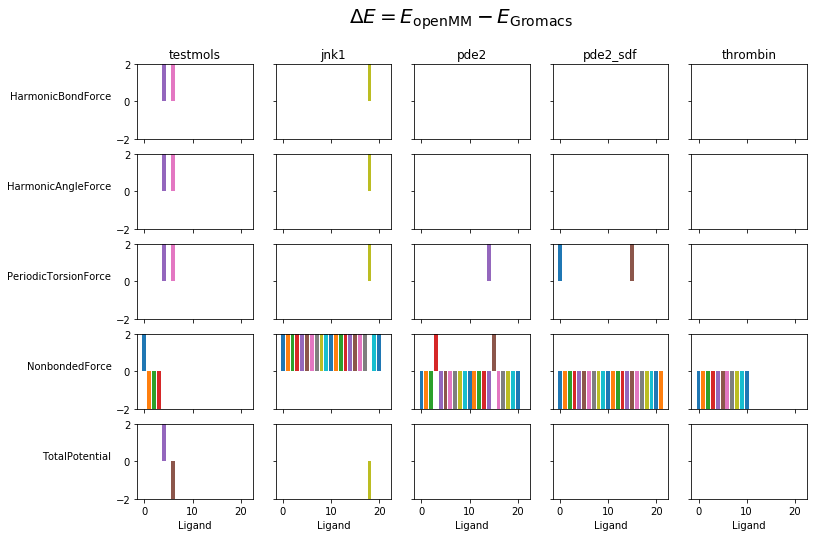

In [17]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(energies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], energies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], energies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_differences_openmm_gromacs.png')
plt.show()

#### Molecules with deviation > 0.01 kJ/mol in one of the terms

=== jnk1 ===
------------------------------------------------------------
--- lig_17124-1 ---
------------------------------------------------------------
    HarmonicBondForce   :    40.93       40.93        0.00
    HarmonicAngleForce  :    56.67       56.67        0.00
    PeriodicTorsionForce:    23.11       23.11        0.00
    NonbondedForce      :     0.00    -1219.61     1219.61
    TotalPotential      : -1098.90    -1098.90        0.00
=== jnk1 ===
------------------------------------------------------------
--- lig_18624-1 ---
------------------------------------------------------------
    HarmonicBondForce   :    16.99       16.99        0.00
    HarmonicAngleForce  :    41.00       41.00       -0.00
    PeriodicTorsionForce:    25.22       25.22       -0.00
    NonbondedForce      :     0.00    -1159.09     1159.09
    TotalPotential      : -1075.88    -1075.89        0.01
=== jnk1 ===
------------------------------------------------------------
--- lig_18625-1 ---
------

------------------------------------------------------------
--- ethanol ---
------------------------------------------------------------
    HarmonicBondForce   :     5.78        0.00        5.78
    HarmonicAngleForce  :     4.62        0.00        4.62
    PeriodicTorsionForce:     8.34        0.00        8.34
    NonbondedForce      :     0.00        0.00        0.00
    TotalPotential      :     8.66        0.00        8.66
=== testmols ===
------------------------------------------------------------
--- phenol ---
------------------------------------------------------------
    HarmonicBondForce   :    11.62        0.00       11.62
    HarmonicAngleForce  :     8.93        0.00        8.93
    PeriodicTorsionForce:    15.11        0.00       15.11
    NonbondedForce      :     0.00        0.00        0.00
    TotalPotential      :   -13.65        0.00      -13.65
=== thrombin ===
------------------------------------------------------------
--- lig_1a ---
-------------------------

/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


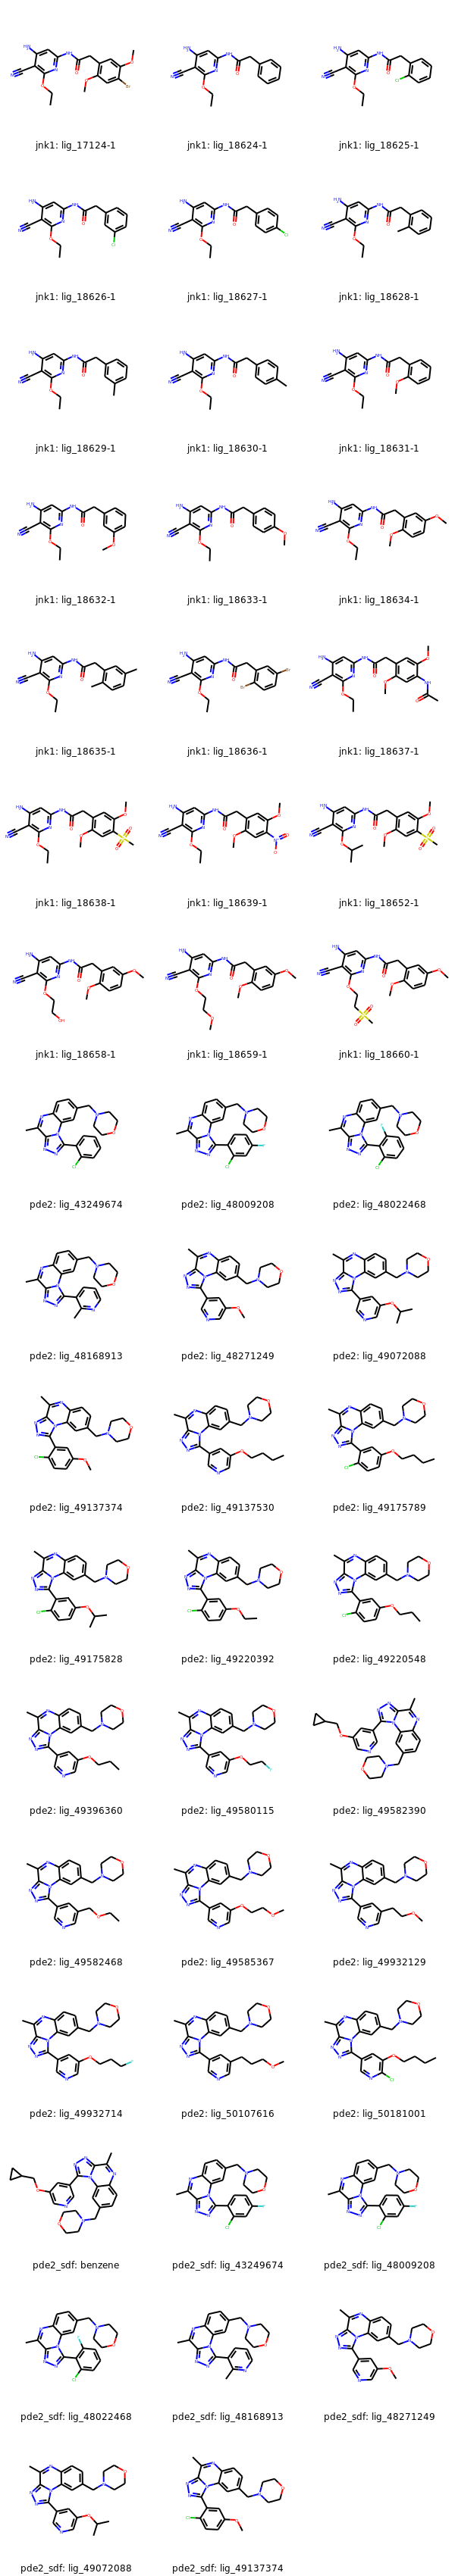

In [18]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
import rdkit.Chem.Draw as D
rdkitMols = []
for i, (target, ligand) in enumerate(np.unique(differing_molecules, axis=0)):
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligPath = 'systems/' + target + '/' + ligand + '/' + ligand
        
    if os.path.isfile(ligPath+'.sdf'):
        print('-' * 60)
        print('--- ' + ligand + ' ---')
        print('-' * 60)
        mols = AllChem.SDMolSupplier(ligPath+'.sdf')
        for mol in mols:
            AllChem.Compute2DCoords(mol)
            mol.SetProp('_Name', target + ': ' + ligand)
            rdkitMols.append(mol)
    for k, item in energies[target][ligand].items():
        print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format(k, item[0], item[1], item[2]))
Draw.MolsToGridImage(rdkitMols, legends=[x.GetProp('_Name') for x in rdkitMols])

#### Minimized Energies

In [19]:
minEnergies={}
print('    {:20s}: {:11s}    {:11s}    {:11s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    minEnergies[target] = {}
    for key in openmmMinimizedEnergies[target].keys():
        print(key)
        minEnergies[target][key] = {}
        for kk, ene in openmmMinimizedEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsMinimizedEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Proper Dih.']
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Potential']
            else:
                print('Error: OpenMM Energy not known.')
            minEnergies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM         Gromacs        Difference 
=== testmols ===
acetone
    HarmonicBondForce   :     0.03        0.25       -0.22
    HarmonicAngleForce  :     0.04        3.20       -3.16
    PeriodicTorsionForce:    20.05       21.84       -1.79
    NonbondedForce      :     0.00      -94.77       94.77
    TotalPotential      :   -73.88        0.00      -73.88
benzaldehyde
    HarmonicBondForce   :     0.94        3.52       -2.58
    HarmonicAngleForce  :     0.30        0.87       -0.56
    PeriodicTorsionForce:     0.00        0.01       -0.01
    NonbondedForce      :     0.00       55.53      -55.53
    TotalPotential      :    55.67        0.00       55.67
benzene
    HarmonicBondForce   :     0.50        0.77       -0.27
    HarmonicAngleForce  :     0.00        1.44       -1.44
    PeriodicTorsionForce:     0.00        0.01       -0.01
    NonbondedForce      :     0.00       24.45      -24.45
    TotalPotential      :    23.46        0.00       23.46
e

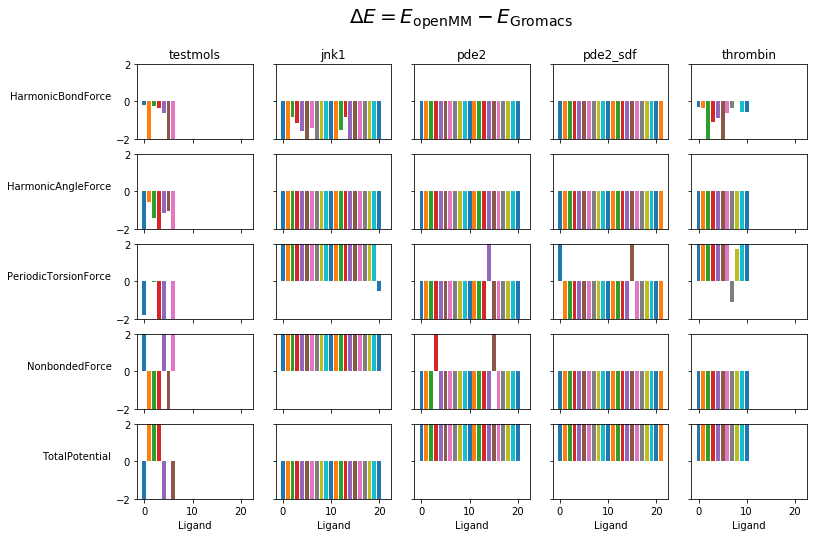

In [20]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(minEnergies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], minEnergies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], minEnergies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_minimized_differences_openmm_gromacs.png')
plt.show()